# Hidden Markov Models (HMMs)

In [78]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

---
### Hidden Markov Model

* Random stochastic transitions between a set of discrete states.
* *Memoryless*: Next transition depends only on the current state, not the past history.
* For temporal sequences, transitions are typically exponentially distributed (i.e. rate consant).
* We don't observe the states directly, but instead we observe a probabilistic output (emission) from each state.
* Observations are random variables from probability distributions that may differ for each state.

![](hmm.png)

The probability of getting a particular sequence of observations $O_1, O_2, ...$ is given by

### $\begin{align}
P(O_1, O_2, ...) &= \sum_{S_1, S_2, ...} P(S_1) P(S_1 \rightarrow O_1) P(S_1 \rightarrow S_2)  P(S_2 \rightarrow O_2) P(S_2 \rightarrow S_3)  P(S_3 \rightarrow O_3) ... \\
                 &= \sum_{S_1, S_2, ...} P(S_1) P(S_1 \rightarrow O_1) \prod_{i \geq 2} P(S_{i-1} \rightarrow S_i)  P(S_i \rightarrow O_i)
\end{align}$

---
### 2-State Markov Model

### State 0 <==> State 1

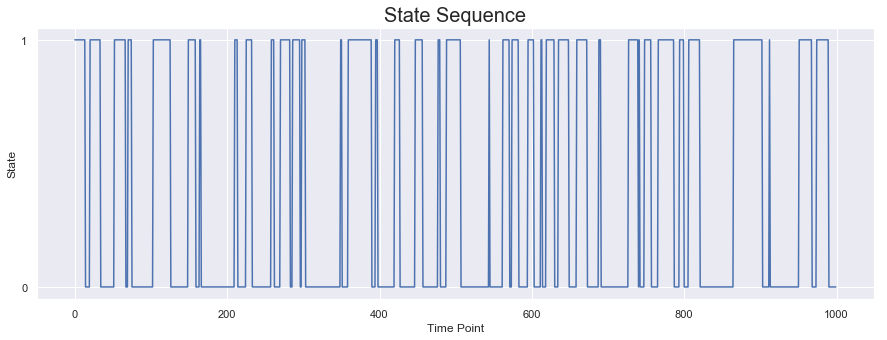

In [79]:
# transition probability matrix for each time step
A = np.array([[0.95, 0.05],   # P(state0->state0), P(state0->state1)
              [0.10, 0.90]])  # P(state1->state0), P(state1->state1)

# initial state probabilities (i.e. probability that we start off in each state)
p0 = np.array([0.5, 0.5])     # P(state0), P(state1)

# number of states
n_states = len(p0)

# list of state indices
states = np.arange(n_states)  # [0, 1]

# state sequence for 1000 time points
state_seq = np.zeros(1000, dtype=int)

# set initial state by drawing from initial state probability array
state_seq[0] = np.random.choice(states, p=p0)

# for each subsequent time point, set the state based on the transition probabilities out of the current state
# if we are in state0, then we stay in state0 with probability 0.95 and go to state1 with probability 0.05
# if we are in state1, then we stay in state1 with probability 0.90 and go to state0 with probability 0.10
for t in range(1, len(state_seq)):
    state_seq[t] = np.random.choice(states, p=A[state_seq[t - 1], :])

plt.figure(figsize=(15, 5))
plt.plot(state_seq)
plt.yticks(states)
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence', fontsize=20);

### Single ion channel gating between closed and open states.

* Interpret the above state sequence as depicting the gating of a single ion channel transitioning between closed and open states.
* Assume we record zero current when the channel is closed (state0), and 5 pA when the channel is open (state1).
* Also assume we have normally distributed noise with std of 1 pA.

0.5

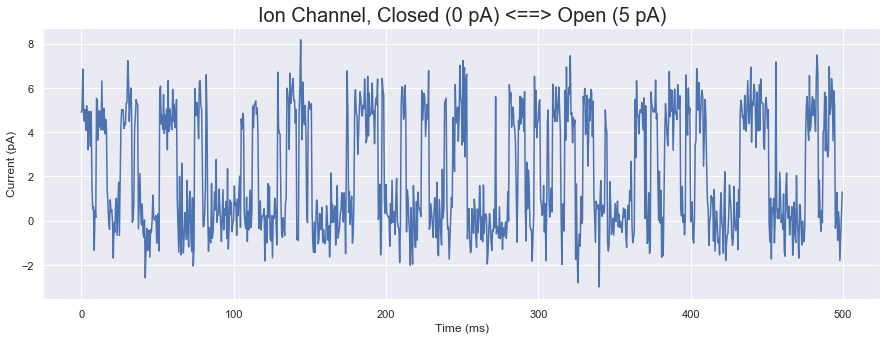

In [80]:
current_pA = state_seq * 5 + np.random.randn(len(state_seq))

sample_freq_kHz = 2
sample_interval_ms = 1 / sample_freq_kHz
time_ms = np.arange(len(current_pA)) * sample_interval_ms

plt.figure(figsize=(15, 5))
plt.plot(time_ms, current_pA)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Ion Channel, Closed (0 pA) <==> Open (5 pA)', fontsize=20)

sample_interval_ms

### The values that we observe when the model is in a given state are random variables from a probability distribution.

* For the above ion channel, we can assign to each state a probability distribution for it to emit an observable (i.e. current).
* In this case, we can assign states 0 and 1 normally distributed current emissions with std 1 pA and means of 0 and 5 pA, respectively.
* But the state emission distributions don't have ot be the same. Let's assume we have std 0.5 pA in the closed state and 1 pA in the open state.

![](hmm.png)

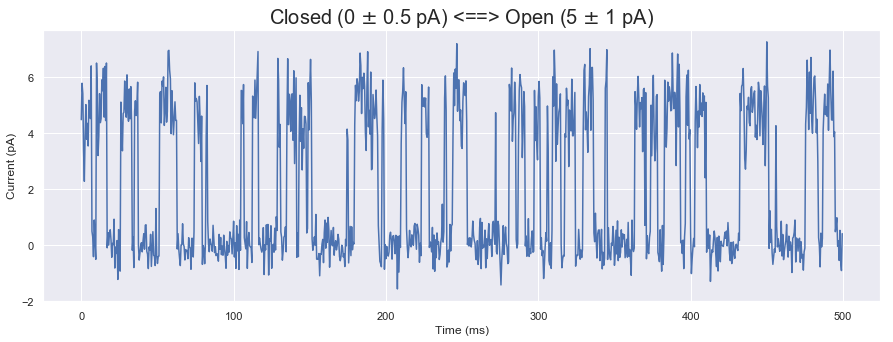

In [81]:
current_pA = np.zeros(state_seq.shape)

closed_pts = np.where(state_seq == 0)[0]
open_pts = np.where(state_seq == 1)[0]

current_pA[closed_pts] = np.random.randn(len(closed_pts)) * 0.5  # closed  0 +/- 0.5 pA
current_pA[open_pts] = 5 + np.random.randn(len(open_pts)) * 1    # open    5 +/- 1.0 pA

plt.figure(figsize=(15, 5))
plt.plot(time_ms, current_pA)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Closed (0 $\pm$ 0.5 pA) <==> Open (5 $\pm$ 1 pA)', fontsize=20);

---
### 3-State HMM: Closed1 <==> Open <==> Closed2

* Let's add a 2nd closed state to the ion channel 2-State model above, so that we now have two closed states and one open state.
* Both closed states emit the same observable current, i.e. zero current.
* Thus, when we observe zero current, we know that the channel is closed, but we don't know which of the two closed states it is in, or even when it might transition back and forth between the closed states. Thus, the states are hidden.

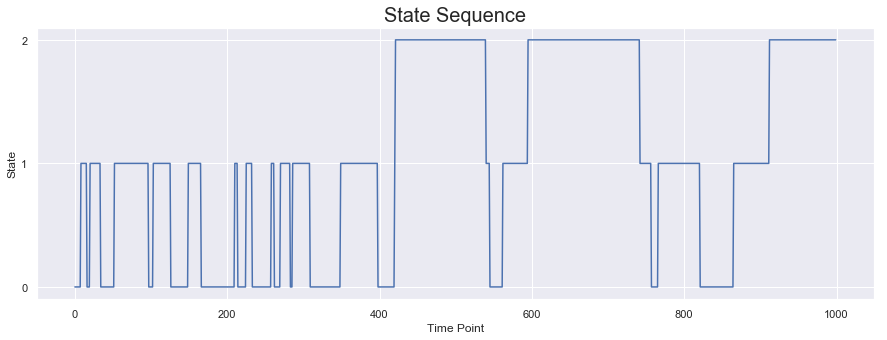

In [82]:
# transition probability matrix for each time step
# closed1 (state0) <==> open (state1) <==> closed2 (state2)
A = np.array([[0.95, 0.05, 0.00],   # P(C1->C1), P(C1->O), P(C1->C2)
              [0.03, 0.95, 0.02],   # P( O->C1), P( O->O), P( O->C2)
              [0.00, 0.005, 0.995]])  # P(C2->C1), P(C2->O), P(C2->C2)

# initial state probabilities (i.e. probability that we start off in each state)
p0 = np.array([1, 0, 0])     # P(C1), P(O), P(C2)

# number of states
n_states = len(p0)

# list of state indices
states = np.arange(n_states)  # [0, 1, 2]

# state sequence for 1000 time points
state_seq = np.zeros(1000, dtype=int)

# set initial state by drawing from initial state probability array
np.random.seed(0)
state_seq[0] = np.random.choice(states, p=p0)

# for each subsequent time point, set the state based on the transition probabilities out of the current state
# if we are in state0, then we stay in state0 with probability 0.95 and go to state1 with probability 0.05
# if we are in state1, then we stay in state1 with probability 0.90 and go to state0 with probability 0.10
for t in range(1, len(state_seq)):
    state_seq[t] = np.random.choice(states, p=A[state_seq[t - 1], :])

plt.figure(figsize=(15, 5))
plt.plot(state_seq)
plt.yticks(states)
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence', fontsize=20);

### Observable current (state emissions).

* Closed and open states pass 0 and 5 pA, respectively.
* Noise is normally distributed with std 0.5 and 1 pA in closed and open states, respectively.

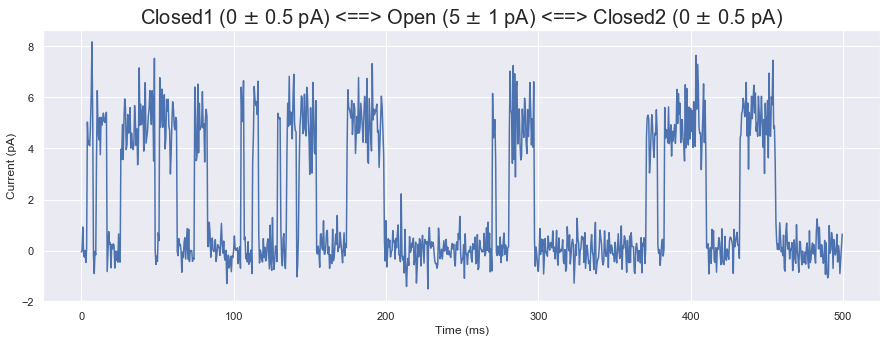

In [83]:
current_pA = np.zeros(state_seq.shape)

closed1_pts = np.where(state_seq == 0)[0]
open_pts = np.where(state_seq == 1)[0]
closed2_pts = np.where(state_seq == 2)[0]

current_pA[closed1_pts] = np.random.randn(len(closed1_pts)) * 0.5  # closed1 = 0 +/- 0.5 pA
current_pA[open_pts] = 5 + np.random.randn(len(open_pts)) * 1      # open = 5 +/- 1 pA
current_pA[closed2_pts] = np.random.randn(len(closed2_pts)) * 0.5  # closed2 = 0 +/- 0.5 pA

plt.figure(figsize=(15, 5))
plt.plot(time_ms, current_pA)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Closed1 (0 $\pm$ 0.5 pA) <==> Open (5 $\pm$ 1 pA) <==> Closed2 (0 $\pm$ 0.5 pA)', fontsize=20);

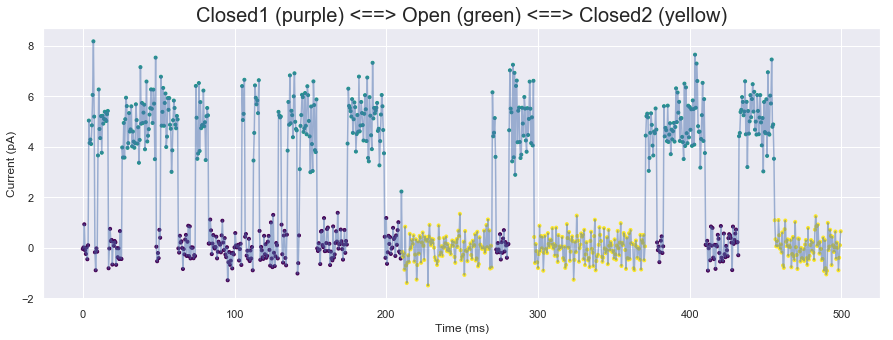

In [84]:
plt.figure(figsize=(15, 5))
plt.plot(time_ms, current_pA, alpha=0.5)
plt.scatter(time_ms, current_pA, c=state_seq, marker='.', cmap='viridis')
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Closed1 (purple) <==> Open (green) <==> Closed2 (yellow)', fontsize=20);

---
### Half amplitude threshold idealization.

* Points below threshold are considered closed, above are considred open.

In [85]:
def make_single_channel_record(n_pts, p0, A, B, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    state_seq = np.zeros(n_pts, dtype=int)
    states = np.arange(len(p0))
    state_seq[0] = np.random.choice(states, p=p0)
    for t in range(1, n_pts):
        state_seq[t] = np.random.choice(states, p=A[state_seq[t - 1], :])
    emission = np.zeros(state_seq.shape)
    for i, (mu, sigma) in enumerate(B):
        pts = np.where(state_seq == i)[0]
        emission[pts] = mu + np.random.randn(len(pts)) * sigma
    return state_seq, emission

In [86]:
state_seq, current_pA = make_single_channel_record(1000000, p0, A, [(0, 0.5), (5, 1), (0, 0.5)], random_state=0)

time_ms = np.arange(len(current_pA)) * sample_interval_ms

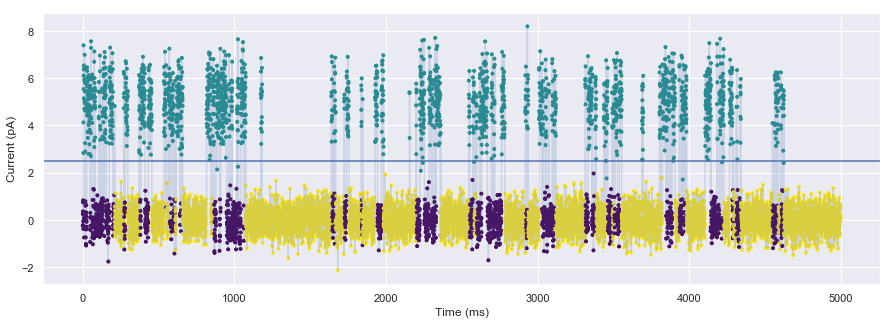

In [87]:
plt.figure(figsize=(15, 5))
n = 10000
plt.plot(time_ms[:n], current_pA[:n], alpha=0.2)
plt.scatter(time_ms[:n], current_pA[:n], marker='.', c=state_seq[:n], cmap='viridis')
plt.axhline(2.5)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)');

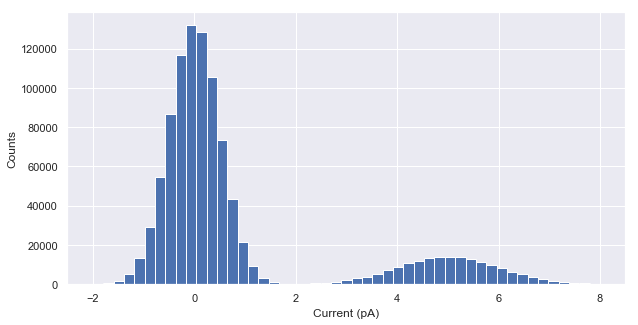

In [88]:
plt.figure(figsize=(10, 5))
plt.hist(current_pA, np.linspace(-2, 8, 50))
plt.xlabel('Current (pA)')
plt.ylabel('Counts');

In [89]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=1)
gmm.fit(current_pA.reshape(-1, 1))

print('amp:', gmm.weights_)
print()
print('mean:', gmm.means_)
print()
print('var', gmm.covariances_)
print()
print('std', np.sqrt(gmm.covariances_))

amp: [0.82512543 0.17487457]

mean: [[-3.78561981e-04]
 [ 4.99887408e+00]]

var [[[0.24925916]]

 [[1.00485671]]]

std [[[0.49925861]]

 [[1.00242541]]]


In [90]:
np.squeeze(gmm.covariances_)

array([0.24925916, 1.00485671])

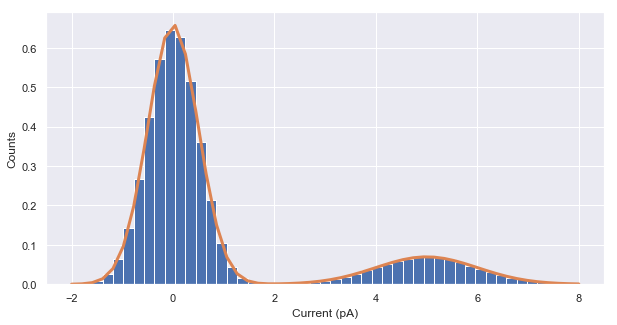

In [91]:
bins = np.linspace(-2, 8, 50)

fit = np.zeros(bins.shape)
for i in range(2):
    amp = gmm.weights_[i]
    mu = np.squeeze(gmm.means_)[i]
    sigma = np.sqrt(np.squeeze(gmm.covariances_)[i])
    fit += amp * st.norm.pdf(bins, mu, sigma)

plt.figure(figsize=(10, 5))
plt.hist(current_pA, bins, density=True)
plt.plot(bins, fit, lw=3)
plt.xlabel('Current (pA)')
plt.ylabel('Counts');

In [92]:
# histogram current bins from 0-5 pA
a = np.where(bins > 0)[0][0]
b = np.where(bins < 5)[0][-1]

# 0-5 pA corresponds to bins indices a-b
a, b

(10, 34)

half-amplitude threshold: 2.4992477599158893
minima between amplitude peaks threshold: 1.8775510204081636


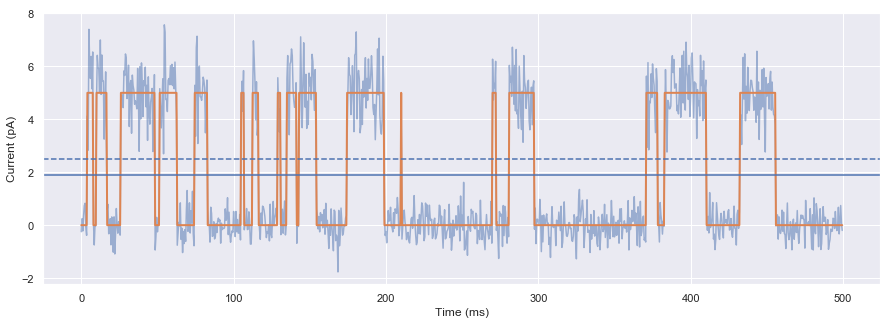

In [93]:
# simple half-amplitude threshold
half_amp_threshold = np.mean(np.squeeze(gmm.means_))
print("half-amplitude threshold:", half_amp_threshold)

# threshold based on minimum between peaks in Gaussian mixture model
binsab = bins[a:b]
between_peaks_threshold = binsab[np.argmin(fit[a:b])]
print("minima between amplitude peaks threshold:", between_peaks_threshold)

threshold = between_peaks_threshold

closed_pts = np.where(current_pA <= threshold)[0]
open_pts = np.where(current_pA > threshold)[0]

ideal = np.zeros(current_pA.shape)
ideal[closed_pts] = np.squeeze(gmm.means_)[0]
ideal[open_pts] = np.squeeze(gmm.means_)[1]

plt.figure(figsize=(15, 5))
n = 1000
plt.plot(time_ms[:n], current_pA[:n], alpha=0.5)
plt.plot(time_ms[:n], ideal[:n], lw=2)
plt.axhline(half_amp_threshold, linestyle='dashed')
plt.axhline(between_peaks_threshold)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)');

---
### Use the Gaussian Mixture Model directly to cluster the points into closed vs. open states based on current amplitude.

This puts each data point into the most probable Gaussian distribution (i.e. distributions for closed or open states).

* We just did this recently!

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])

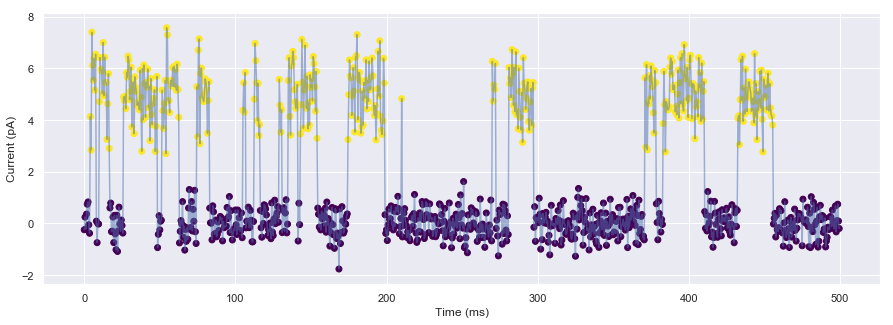

In [94]:
cluster_seq = gmm.predict(current_pA.reshape(-1, 1))

plt.figure(figsize=(15, 5))
n = 1000
plt.plot(time_ms[:n], current_pA[:n], alpha=0.5)
plt.scatter(time_ms[:n], current_pA[:n], marker='o', c=cluster_seq[:n], cmap='viridis')
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)');

cluster_seq[:20]

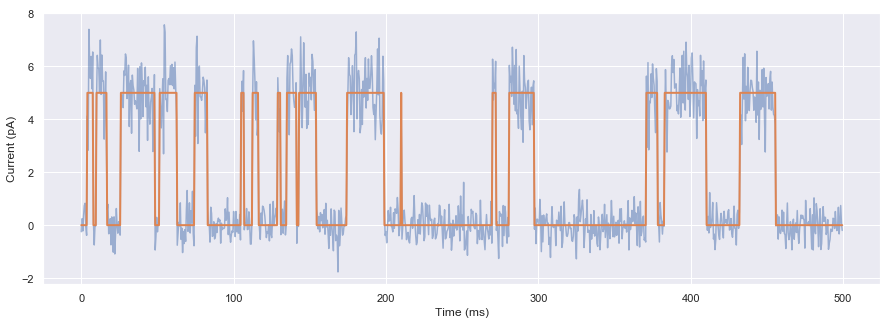

In [95]:
closed_pts = np.where(cluster_seq == 0)[0]
open_pts = np.where(cluster_seq == 1)[0]

ideal = np.zeros(current_pA.shape)
ideal[closed_pts] = np.squeeze(gmm.means_)[0]
ideal[open_pts] = np.squeeze(gmm.means_)[1]

plt.figure(figsize=(15, 5))
n = 1000
plt.plot(time_ms[:n], current_pA[:n], alpha=0.5)
plt.plot(time_ms[:n], ideal[:n], lw=2)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)');

---
### Exponential dwell times (state lifetimes)

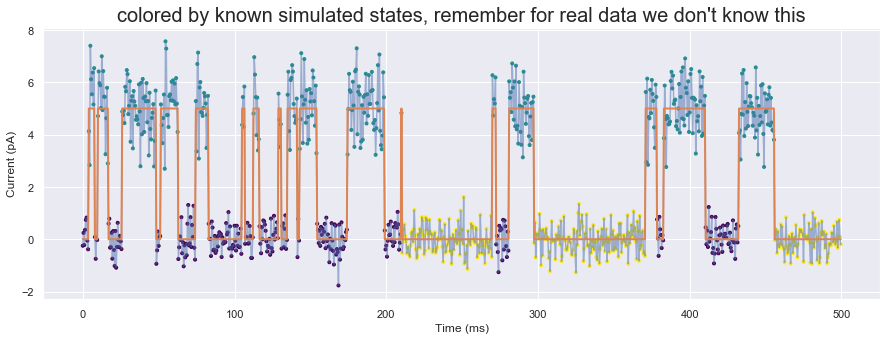

In [96]:
plt.figure(figsize=(15, 5))
n = 1000
plt.plot(time_ms[:n], current_pA[:n], alpha=0.5)
plt.scatter(time_ms[:n], current_pA[:n], marker='.', c=state_seq[:n], cmap='viridis')
plt.plot(time_ms[:n], ideal[:n], lw=2)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title("colored by known simulated states, remember for real data we don't know this", fontsize=20);

In [97]:
cluster_seq[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])

In [98]:
np.diff(cluster_seq[:20])

array([ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0])

In [99]:
co_pts = np.where(np.diff(cluster_seq) == 1)[0]
oc_pts = np.where(np.diff(cluster_seq) == -1)[0]

co_pts[:9], oc_pts[:9]

(array([  7,  19,  51, 102, 148, 209, 224, 257, 269]),
 array([ 15,  33,  96, 125, 165, 213, 232, 261, 282]))

In [100]:
N = min(len(co_pts), len(oc_pts))

open_durations_pts = oc_pts[:N] - co_pts[:N]
closed_durations_pts = co_pts[1:N] - oc_pts[:N-1]

open_durations_pts[:9], closed_durations_pts[:9]

(array([ 8, 14, 45, 23, 17,  4,  8,  4, 13]),
 array([ 4, 18,  6, 23, 44, 11, 25,  8,  3]))

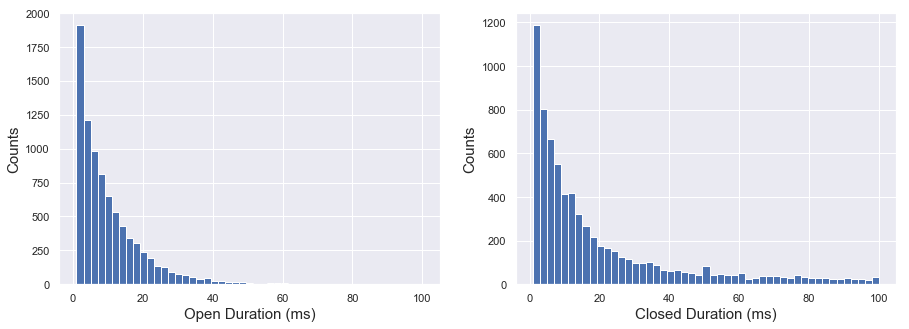

In [101]:
open_durations_ms = open_durations_pts * sample_interval_ms
closed_durations_ms = closed_durations_pts * sample_interval_ms

plt.figure(figsize=(15, 5))

plt.subplot(121)
binedges = np.linspace(1, 100, 50)
plt.hist(open_durations_ms, binedges)
plt.xlabel('Open Duration (ms)', fontsize=15)
plt.ylabel('Counts', fontsize=15)

plt.subplot(122)
binedges = np.linspace(1, 100, 50)
plt.hist(closed_durations_ms, binedges)
plt.xlabel('Closed Duration (ms)', fontsize=15)
plt.ylabel('Counts', fontsize=15);

### Plotting the dwell time histogram on a $log$ scale results in nonuniform bin widths.

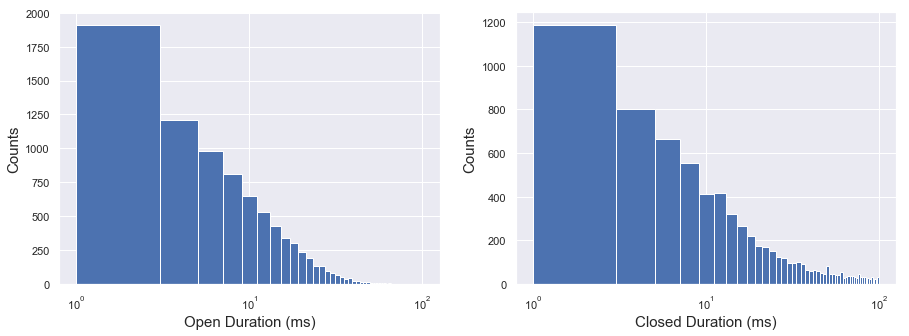

In [102]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
binedges = np.linspace(1, 100, 50)
plt.hist(open_durations_ms, binedges)
plt.xscale('log')
plt.xlabel('Open Duration (ms)', fontsize=15)
plt.ylabel('Counts', fontsize=15)

plt.subplot(122)
plt.hist(closed_durations_ms, binedges)
plt.xscale('log')
plt.xlabel('Closed Duration (ms)', fontsize=15)
plt.ylabel('Counts', fontsize=15);

### Instead, we take the $log$ of the dwell times and then create a histogram from that with evenly spaced logscale bin widths.

* The advantage of this representation of the data is that exponential distributions have a peak on a log scale at their time constant, which can make resolving multiple components more visually obvious.
* Note that $np.log$ is base $e$ (i.e. the natural logarithm), not base 10.

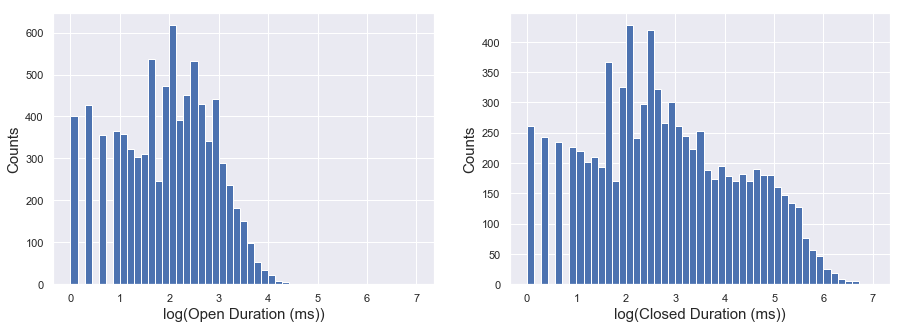

In [103]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
logbinedges = np.linspace(0, 7, 50)
plt.hist(np.log(open_durations_ms), logbinedges)
plt.xlabel('log(Open Duration (ms))', fontsize=15)
plt.ylabel('Counts', fontsize=15)

plt.subplot(122)
logbinedges = np.linspace(0, 7, 50)
plt.hist(np.log(closed_durations_ms), logbinedges)
plt.xlabel('log(Closed Duration (ms))', fontsize=15)
plt.ylabel('Counts', fontsize=15);

---
### Maximum likelihood exponential fitting of dwell time distributuions.

* Remember this?

In [104]:
# fit open durations to a single exponential distribution
_, open_tau_ms = st.expon.fit(open_durations_ms, floc=0)

open_tau_ms, np.log(open_tau_ms)

(9.7969398049546, 2.2820700721111704)

### The closed lifetimes have two obvious components (it's one for each closed state).

### To fit those we'll need to write a cost function and minimize the negative loglikelihood of a biexponential $PDF$ for the closed durations.

* Rememebr this?

In [105]:
# fit closed durations to a biexponential distribution (i.e. weighted sum of two exponential distributions)
import scipy.optimize as opt

def biexp_pdf(t, params):
    A1, tau1_ms, tau2_ms = params
    # This is just a weighted sum of two exponential PDFs.
    # The weights need to sum to one so that the combined probability of the two distributions is still one.
    return A1 * st.expon.pdf(t, 0, tau1_ms) + (1 - A1) * st.expon.pdf(t, 0, tau2_ms)

def closed_durations_biexp_negLL(params):
    pdf = biexp_pdf(closed_durations_ms, params)
    return -np.log(pdf).sum()

bnds = opt.Bounds([0, 1, 1], [1, 1000, 1000])  # lower bounds, upper bounds
result = opt.minimize(closed_durations_biexp_negLL, [0.5, 10, 100], method='slsqp', bounds=bnds)
print(result)

     fun: 40730.11935807144
     jac: array([ 0.00292969, -0.00097656, -0.00048828])
 message: 'Optimization terminated successfully.'
    nfev: 55
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([  0.60521859,  10.03638646, 101.73598677])


In [106]:
# parameters for closed durations fit
closed_A1, closed_tau1_ms, closed_tau2_ms = result.x
closed_A2 = 1 - closed_A1

print(f'{closed_tau1_ms:.1f} ms ({(closed_A1 * 100):.1f} %)')
print(f'{closed_tau2_ms:.1f} ms ({(closed_A2 * 100):.1f} %)')

10.0 ms (60.5 %)
101.7 ms (39.5 %)


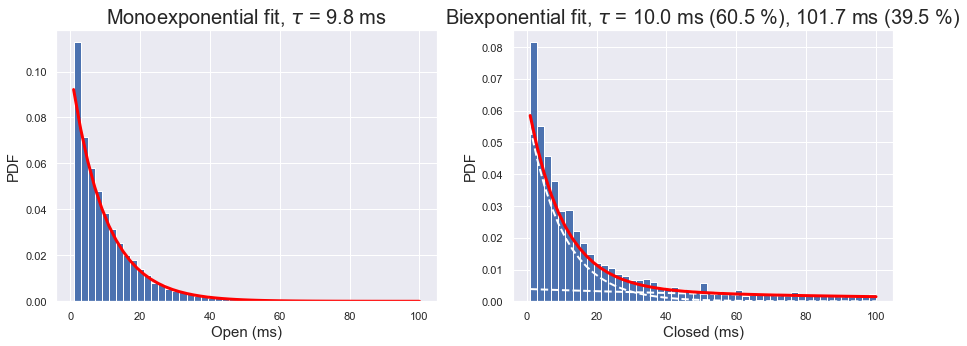

In [107]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
binedges = np.linspace(1, 100, 50)
plt.hist(open_durations_ms, binedges, density=True)
plt.plot(binedges, st.expon.pdf(binedges, 0, open_tau_ms), lw=3, color='red')
plt.xlabel('Open (ms)', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.title(rf'Monoexponential fit, $\tau$ = {open_tau_ms:.1f} ms', fontsize=20)

plt.subplot(122)
binedges = np.linspace(1, 100, 50)
plt.hist(closed_durations_ms, binedges, density=True)
plt.plot(binedges, closed_A1 * st.expon.pdf(binedges, 0, closed_tau1_ms), '--', lw=2, color='white')
plt.plot(binedges, closed_A2 * st.expon.pdf(binedges, 0, closed_tau2_ms), '--', lw=2, color='white')
plt.plot(binedges, biexp_pdf(binedges, result.x), lw=3, color='red')
plt.xlabel('Closed (ms)', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.title(rf'Biexponential fit, $\tau$ = {closed_tau1_ms:.1f} ms ({(closed_A1 * 100):.1f} %), {closed_tau2_ms:.1f} ms ({(closed_A2 * 100):.1f} %)', fontsize=20);

sum of open time probability = 1.0
sum of closed time probability = 1.0


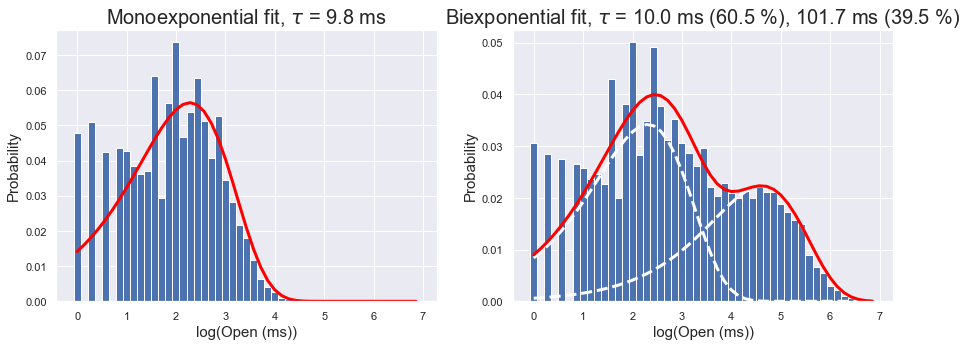

In [108]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
logbinedges = np.linspace(0, 7, 50)
logbinwidth = np.diff(logbinedges[:2])
binedges = np.exp(logbinedges)
binwidths = np.diff(binedges)

# probability = pdf * binwidths
pdf, edges = np.histogram(open_durations_ms, binedges, density=True)
probability = pdf.astype(float) * binwidths
plt.bar(logbinedges[:-1], probability, width=logbinwidth)
print('sum of open time probability =', probability.sum())

# fit probability = pdf * binwidths
pdf = st.expon.pdf(binedges[:-1], 0, open_tau_ms)
plt.plot(logbinedges[:-1], pdf * binwidths, lw=3, color='red')
plt.xlabel('log(Open (ms))', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.title(rf'Monoexponential fit, $\tau$ = {open_tau_ms:.1f} ms', fontsize=20)



plt.subplot(122)
logbinedges = np.linspace(0, 7, 50)
logbinwidth = np.diff(logbinedges[:2])
binedges = np.exp(logbinedges)
binwidths = np.diff(binedges)

# probability = pdf * binwidths
pdf, edges = np.histogram(closed_durations_ms, binedges, density=True)
probability = pdf.astype(float) * binwidths
plt.bar(logbinedges[:-1], probability, width=logbinwidth)
print('sum of closed time probability =', probability.sum())

# fit probability = pdf * binwidths
pdf = closed_A1 * st.expon.pdf(binedges[:-1], 0, closed_tau1_ms)
plt.plot(logbinedges[:-1], pdf * binwidths, '--', lw=3, color='white')
pdf = closed_A2 * st.expon.pdf(binedges[:-1], 0, closed_tau2_ms)
plt.plot(logbinedges[:-1], pdf * binwidths, '--', lw=3, color='white')
pdf = biexp_pdf(binedges[:-1], [closed_A1, closed_tau1_ms, closed_tau2_ms])
plt.plot(logbinedges[:-1], pdf * binwidths, lw=3, color='red')
plt.xlabel('log(Open (ms))', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.title(rf'Biexponential fit, $\tau$ = {closed_tau1_ms:.1f} ms ({(closed_A1 * 100):.1f} %), {closed_tau2_ms:.1f} ms ({(closed_A2 * 100):.1f} %)', fontsize=20);

---
### Transition probabilities and rate constants

* Transition rate constants are the average expected number of transitions per some unit of time (e.g. 100 $s^{-1}$).
* The time constant ($\tau$) of an exponential distribution is the average time for that distribution.
* The exponential fits to the dwell time distributions are the expected average time spent in each conductance level before transitioning to another level.
* The dwell time, or lifetime in a given state is the inverse of the rate at which the model leaves that state.
* Thus, given an open state described by a single exponential with $\tau$ = 10 ms, the rate at which we exit the open state (i.e. go to the closed state) is 1 / 10 ms = 100 $s^{-1}$
* However, the above is the net rate of leaving the open state, which may be distributed amongst transitions to several closed states.
* e.g. we might transition from open to closed1 at a rate of 60 $s^{-1}$, and from open to closed2 at a rate of 40 $s^{-1}$
* For a given rate constant $k$ to leave a state, the probability that we will remain in the state after one sample interval $dt$ is given by the probability under an exponential $PDF$ with time constant $\tau = 1/k$ integrated from time zero to $dt$.

In [109]:
# probability that we leave the open state after one sample interval
st.expon.cdf(sample_interval_ms, loc=0, scale=open_tau_ms)

0.04975586673472067

In [110]:
# probability that we stay in the open state after one sample interval
1 - st.expon.cdf(sample_interval_ms, loc=0, scale=open_tau_ms)

0.9502441332652793

In [111]:
A

array([[0.95 , 0.05 , 0.   ],
       [0.03 , 0.95 , 0.02 ],
       [0.   , 0.005, 0.995]])

In [112]:
# probabilities that we stay in the closed1 state after one sample interval
1 - st.expon.cdf(sample_interval_ms, loc=0, scale=closed_tau1_ms)

0.9514018720865923

In [113]:
# probabilities that we stay in the closed2 state after one sample interval
1 - st.expon.cdf(sample_interval_ms, loc=0, scale=closed_tau2_ms)

0.9950973755134023

In [114]:
rate_leaving_open_state_per_sec = 1000 / open_tau_ms

rate_leaving_open_state_per_sec

102.07269003472601

In [115]:
# approximate probability that we leave the open state after one sample interval (assuming sample interval is small)
rate_leaving_open_state_per_sec * (sample_interval_ms / 1000)

0.051036345017363004

---
### Filtering and missed events

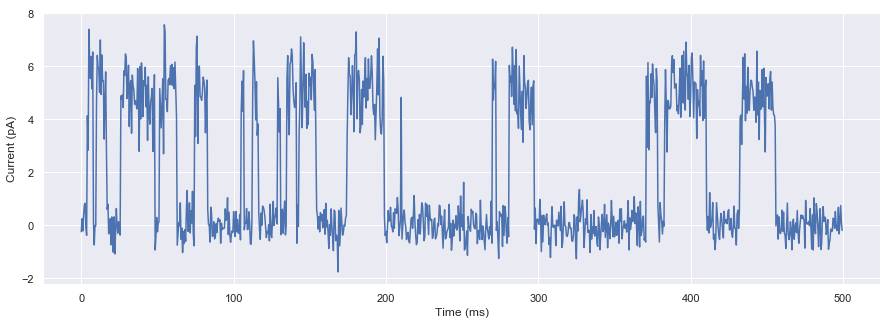

In [116]:
plt.figure(figsize=(15, 5))
n = 1000
plt.plot(time_ms[:n], current_pA[:n])
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)');

In [120]:
sample_interval_ms = time_ms[1] - time_ms[0]
sample_frequency_kHz = 1 / sample_interval_ms

sample_interval_ms, sample_frequency_kHz

(0.5, 2.0)

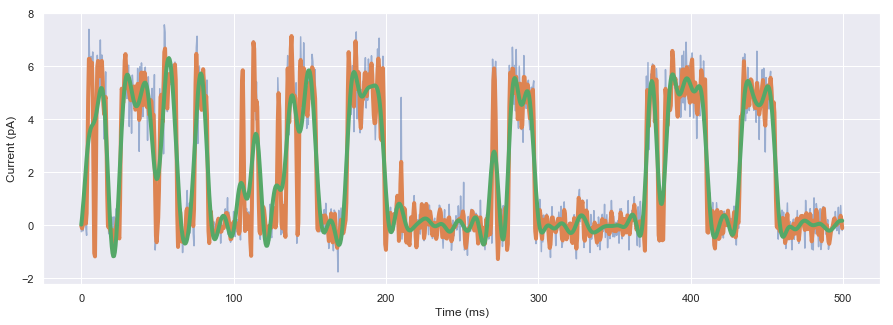

In [126]:
from scipy import signal

lowpass1 = signal.firwin(101, 0.5, nyq=sample_frequency_kHz / 2)
lowpass2 = signal.firwin(101, 0.1, nyq=sample_frequency_kHz / 2)

filtered1_current_pA = np.convolve(current_pA, lowpass1, 'same')
filtered2_current_pA = np.convolve(current_pA, lowpass2, 'same')

plt.figure(figsize=(15, 5))
n = 1000
plt.plot(time_ms[:n], current_pA[:n], alpha=0.5)
plt.plot(time_ms[:n], filtered1_current_pA[:n], lw=4)
plt.plot(time_ms[:n], filtered2_current_pA[:n], lw=4)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)');

### pomegranate HMM

In [39]:
from pomegranate import *

# >>> conda update conda
# >>> conda install pomegranate

In [40]:
hmm = HiddenMarkovModel()

# states
C1 = State(NormalDistribution(0, 0.5), name='Closed1')
O = State(NormalDistribution(5, 1), name='Open')
C2 = State(NormalDistribution(0, 0.5), name='Closed2')

# add states to HMM
hmm.add_states([C1, O, C2])

# recall our initial state probabilities (i.e. probability that we start off in each state)
p0 = np.array([1, 0, 0])     # P(C1), P(O), P(C2)

# we can do the same thing here by adding transition probabilities from a 'start' state to the various states in our model
hmm.add_transition(hmm.start, C1, 1)

# e.g. if we wanted to start in C1 or C2 with equal probability, ...
# hmm.add_transition(hmm.start, C1, 0.5)
# hmm.add_transition(hmm.start, C1, 0.5)


# recall out transition probability matrix for each time step
# closed1 (state0) <==> open (state1) <==> closed2 (state2)
A = np.array([[0.95, 0.05, 0.00],   # P(C1->C1), P(C1->O), P(C1->C2)
              [0.03, 0.95, 0.02],   # P( O->C1), P( O->O), P( O->C2)
              [0.00, 0.005, 0.995]])  # P(C2->C1), P(C2->O), P(C2->C2)

# here, we explicitly add transitions with defined probabilities
hmm.add_transition(C1, C1, 0.95)  # P(C1 -> C1) = 0.95
hmm.add_transition(C1, O, 0.05)   # P(C1 -> O)  = 0.05

hmm.add_transition(O, C1, 0.03)
hmm.add_transition(O, O, 0.95)
hmm.add_transition(O, C2, 0.02)

hmm.add_transition(C2, O, 0.005)
hmm.add_transition(C2, C2, 0.995)

# we have to bake the HMM before it is ready to use!
hmm.bake()

In [41]:
# !!! after we bake the HMM, the order of our states may be changed :(
# but we can easily get the new order from the HMM
states = [state.name for state in hmm.states]

# !!! None-start and None-end specify how state sequences start and end, but they are not actual states in the sequence
states

['Closed1', 'Closed2', 'Open', 'None-start', 'None-end']

In [42]:
hmm.dense_transition_matrix()

array([[0.95 , 0.   , 0.05 , 0.   , 0.   ],
       [0.   , 0.995, 0.005, 0.   , 0.   ],
       [0.03 , 0.02 , 0.95 , 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ]])

In [43]:
import pandas as pd

df = pd.DataFrame(hmm.dense_transition_matrix(), index=states, columns=states)

df

,Closed1,Closed2,Open,None-start,None-end
Closed1,0.95,0.000,0.050,0.0,0.0
Closed2,0.00,0.995,0.005,0.0,0.0
Open,0.03,0.020,0.950,0.0,0.0
None-start,1.00,0.000,0.000,0.0,0.0
None-end,0.00,0.000,0.000,0.0,0.0


In [44]:
df[:3][states[:3]]

,Closed1,Closed2,Open
Closed1,0.95,0.000,0.050
Closed2,0.00,0.995,0.005
Open,0.03,0.020,0.950


### Probability of the current observations given the HMM.

In [45]:
hmm.probability(current_pA)  # underflow (value below smallest possible digital representation)

0.0

In [46]:
hmm.probability(current_pA[:100])  # less points

6.410415789073756e-64

In [47]:
logp_hmm_with_sim_params = hmm.log_probability(current_pA)  # addition instead of multiplication of probabilities mitigates underflow problem

logp_hmm_with_sim_params

-926702.4589111953

### Training an HMM on observed sequences

* Usually, you don't know what the best model parameters are.
* Typically, you start by postulating a model with defined states and transition probabilities that seem reasonable.
* Then, starting from your initial guesses, you fit the model to your observed data sequences to refine your estimates of the parameters.

In [48]:
?hmm.fit

Docstring:
Fit the model to data using either Baum-Welch, Viterbi, or supervised training.

Given a list of sequences, performs re-estimation on the model
parameters. The two supported algorithms are "baum-welch", "viterbi",
and "labeled", indicating their respective algorithm. "labeled"
corresponds to supervised learning that requires passing in a matching
list of labels for each symbol seen in the sequences.

Training supports a wide variety of other options including using
edge pseudocounts and either edge or distribution inertia.

Parameters
----------
sequences : array-like
    An array of some sort (list, numpy.ndarray, tuple..) of sequences,
    where each sequence is a numpy array, which is 1 dimensional if
    the HMM is a one dimensional array, or multidimensional if the HMM
    supports multiple dimensions.

weights : array-like or None, optional
    An array of weights, one for each sequence to train on. If None,
    all sequences are equally weighted. Default is None.

lab

### Initial guess for the HMM transition probabilities.

* Since these are the parameters used to simulate the current data, these guesses are exactly right!

In [49]:
df[:3][states[:3]]

,Closed1,Closed2,Open
Closed1,0.95,0.000,0.050
Closed2,0.00,0.995,0.005
Open,0.03,0.020,0.950


### Fit the HMM to the first 1,000 time points of the observed current using the Baum-Welch expectation maximization (EM) algorithm.

* Notice that the estimated transition probabilities have changed a bit from our initial guess.

In [50]:
hmm.fit([current_pA[:1000]], algorithm='baum-welch')

df = pd.DataFrame(hmm.dense_transition_matrix(), index=states, columns=states)

df[:3][states[:3]]

,Closed1,Closed2,Open
Closed1,0.938531,0.000000,0.061469
Closed2,0.000000,0.986341,0.013659
Open,0.026696,0.020008,0.953296


### Let's make a new model and start with initial parameters that are not exactly those used to simulate the observed current data.

In [51]:
hmm = HiddenMarkovModel()

C1 = State(NormalDistribution(0, 1), name='Closed1')
O = State(NormalDistribution(4, 1), name='Open')
C2 = State(NormalDistribution(0, 1), name='Closed2')

hmm.add_states([C1, O, C2])

hmm.add_transition(hmm.start, C1, 1)

hmm.add_transition(C1, C1, 0.90)
hmm.add_transition(C1, O, 0.1)

hmm.add_transition(O, C1, 0.01)
hmm.add_transition(O, O, 0.98)
hmm.add_transition(O, C2, 0.01)

hmm.add_transition(C2, O, 0.10)
hmm.add_transition(C2, C2, 0.90)

hmm.bake()

In [52]:
transition_probabilities = pd.DataFrame(hmm.dense_transition_matrix(), index=states, columns=states)

transition_probabilities[:3][states[:3]]

,Closed1,Closed2,Open
Closed1,0.90,0.00,0.10
Closed2,0.00,0.90,0.10
Open,0.01,0.01,0.98


In [53]:
[state.distribution.parameters for state in hmm.states[:3]]

[[0.0, 1.0], [0.0, 1.0], [4.0, 1.0]]

In [54]:
state_emissions = pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], index=states[:3], columns=['mean', 'std'])

state_emissions

,mean,std
Closed1,0.0,1.0
Closed2,0.0,1.0
Open,4.0,1.0


In [55]:
logp_hmm_with_guess_params = hmm.log_probability(current_pA)

logp_hmm_with_sim_params, logp_hmm_with_guess_params

(-926702.4589111953, -1340099.5059547983)

### Fit the new HMM to the first 1,000 time points of the observed current using the Baum-Welch expectation maximization (EM) algorithm.

In [56]:
hmm.fit([current_pA[:1000]], algorithm='baum-welch')

transition_probabilities = pd.DataFrame(hmm.dense_transition_matrix(), index=states, columns=states)

transition_probabilities[:3][states[:3]]

,Closed1,Closed2,Open
Closed1,0.938527,0.000000,0.061473
Closed2,0.000000,0.986339,0.013661
Open,0.026692,0.020012,0.953296


In [57]:
state_emissions = pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], index=states[:3], columns=['mean', 'std'])

state_emissions

,mean,std
Closed1,0.034657,0.485420
Closed2,-0.019458,0.497382
Open,5.043348,0.986222


### Fit the new HMM to the first 100,000 time points of the observed current using the Baum-Welch expectation maximization (EM) algorithm.

* Notice that as compared to our fit of only the firts 1000 points, our new estimated transition probabilities are closer to those used to simulate this data.
* i.e. with more data we got a better estimate from the fit.

In [58]:
hmm.fit([current_pA[:100000]], algorithm='baum-welch')

transition_probabilities = pd.DataFrame(hmm.dense_transition_matrix(), index=states, columns=states)

transition_probabilities[:3][states[:3]]

,Closed1,Closed2,Open
Closed1,0.954672,0.000000,0.045328
Closed2,0.000000,0.995693,0.004307
Open,0.032140,0.016802,0.951058


In [59]:
state_emissions = pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], index=states[:3], columns=['mean', 'std'])

state_emissions

,mean,std
Closed1,0.003166,0.502295
Closed2,0.000468,0.497477
Open,5.009036,1.005827


In [60]:
logp_hmm_with_fit_params = hmm.log_probability(current_pA)

logp_hmm_with_sim_params, logp_hmm_with_guess_params, logp_hmm_with_fit_params

(-926702.4589111953, -1340099.5059547983, -926743.5189370128)

### Fit the new HMM to the first 100,000 time points of the observed current using the Viterbi algorithm.

In [61]:
hmm.fit([current_pA[:100000]], algorithm='viterbi')

transition_probabilities = pd.DataFrame(hmm.dense_transition_matrix(), index=states, columns=states)

transition_probabilities[:3][states[:3]]

,Closed1,Closed2,Open
Closed1,0.952704,0.000000,0.047296
Closed2,0.000000,0.996494,0.003506
Open,0.035438,0.013548,0.951013


In [62]:
state_emissions = pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], index=states[:3], columns=['mean', 'std'])

state_emissions

,mean,std
Closed1,0.004116,0.502032
Closed2,0.000255,0.497460
Open,5.009220,1.005419


### Baum-Welch expectation maximization (EM) algorithm.

##### Find the model parameters that maximize the probability of a given observation sequence.

### Viterbi algorithm.

##### Find the most likely state sequence given the observation sequence and the model parameters.

* Explanation and python implementation at https://en.wikipedia.org/wiki/Viterbi_algorithm

### Use the trained HMM to predict the state sequence underlying a sequence of observations.

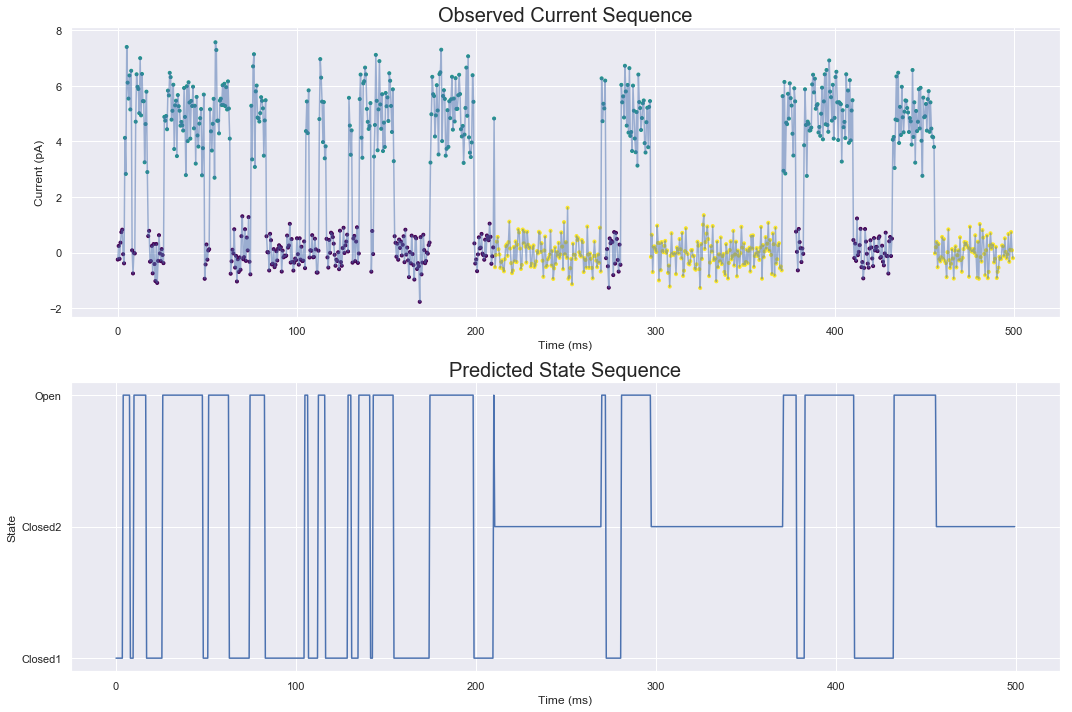

In [63]:
n = 1000

predicted_state_seq = hmm.predict(current_pA[:n])

plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.plot(time_ms[:n], current_pA[:n], alpha=0.5)
plt.scatter(time_ms[:n], current_pA[:n], marker='.', c=state_seq[:n], cmap='viridis')
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Observed Current Sequence', fontsize=20)

plt.subplot(212)
plt.plot(time_ms[:n], predicted_state_seq)
plt.yticks([0, 1, 2], states[:3])
plt.xlabel('Time (ms)')
plt.ylabel('State')
plt.title('Predicted State Sequence', fontsize=20)

plt.tight_layout();

### Use the trained HMM to predict the probability to be in each state at every time point.

In [64]:
n = 1000

predicted_state_prob = hmm.predict_proba(current_pA[:n])
predicted_state_logprob = hmm.predict_log_proba(current_pA[:n])

predicted_state_prob.shape, predicted_state_logprob.shape

((1000, 3), (1000, 3))

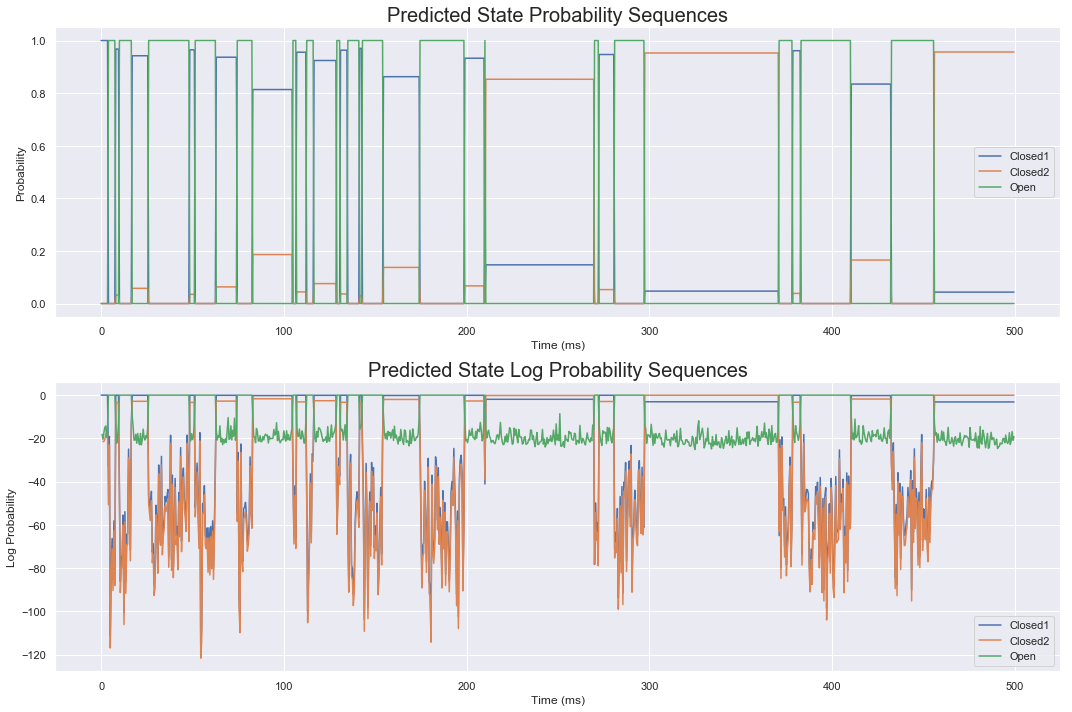

In [65]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.plot(time_ms[:n], predicted_state_prob)
plt.xlabel('Time (ms)')
plt.ylabel('Probability')
plt.title('Predicted State Probability Sequences', fontsize=20)
plt.legend(states[:3])

plt.subplot(212)
plt.plot(time_ms[:n], predicted_state_logprob)
plt.xlabel('Time (ms)')
plt.ylabel('Log Probability')
plt.title('Predicted State Log Probability Sequences', fontsize=20)
plt.legend(states[:3])

plt.tight_layout();

### How to choose a model?

In [66]:
hmm2 = HiddenMarkovModel()

C1 = State(NormalDistribution(0, 1), name='Closed1')
O = State(NormalDistribution(4, 1), name='Open')
C2 = State(NormalDistribution(0, 1), name='Closed2')

hmm2.add_states([C1, O, C2])

hmm2.add_transition(hmm2.start, C1, 1)

hmm2.add_transition(C1, C1, 0.90)
hmm2.add_transition(C1, O, 0.05)
hmm2.add_transition(C1, C2, 0.05)

hmm2.add_transition(O, C1, 0.05)
hmm2.add_transition(O, O, 0.90)
hmm2.add_transition(O, C2, 0.05)

hmm2.add_transition(C2, C1, 0.05)
hmm2.add_transition(C2, O, 0.05)
hmm2.add_transition(C2, C2, 0.90)

hmm2.bake()

In [67]:
hmm.fit([current_pA[:10000]], algorithm='baum-welch')
hmm2.fit([current_pA[:10000]], algorithm='baum-welch')

transition_probabilities = pd.DataFrame(hmm.dense_transition_matrix(), index=states, columns=states)
transition_probabilities2 = pd.DataFrame(hmm2.dense_transition_matrix(), index=states, columns=states)

state_emissions = pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], index=states[:3], columns=['mean', 'std'])
state_emissions2 = pd.DataFrame([state.distribution.parameters for state in hmm2.states[:3]], index=states[:3], columns=['mean', 'std'])

In [68]:
transition_probabilities[:3][states[:3]]

,Closed1,Closed2,Open
Closed1,0.950527,0.000000,0.049473
Closed2,0.000000,0.995375,0.004625
Open,0.039688,0.013768,0.946544


In [69]:
transition_probabilities2[:3][states[:3]]

,Closed1,Closed2,Open
Closed1,0.952215,9.962340e-03,3.782230e-02
Closed2,0.006008,9.939924e-01,3.781847e-09
Open,0.053454,8.049978e-10,9.465460e-01


In [70]:
state_emissions

,mean,std
Closed1,-0.015161,0.499617
Closed2,-0.006801,0.497356
Open,5.001332,0.990476


In [71]:
state_emissions2

,mean,std
Closed1,-0.011294,0.504761
Closed2,-0.006989,0.493533
Open,5.001351,0.990446


In [72]:
hmm.log_probability(current_pA), hmm2.log_probability(current_pA)

(-927099.2897224294, -927153.5267693884)

#### $AIC = -2 * loglikelihood + 2 * (# of model parameters)$

#### $BIC = -2 * loglikelihood + log(# of data points) * (# of model parameters)$

In [74]:
aic = -2 * hmm.log_probability(current_pA) + 2 * (3 * 2 + 4)
aic2 = -2 * hmm2.log_probability(current_pA) + 2 * (3 * 2 + 6)

bic = -2 * hmm.log_probability(current_pA) + np.log(len(current_pA)) * (3 * 2 + 4)
bic2 = -2 * hmm2.log_probability(current_pA) + np.log(len(current_pA)) * (3 * 2 + 6)

print('AIC:', aic, aic2, 'minimum is best')
print('BIC:', bic, bic2, 'minimum is best')

AIC: 1854218.5794448587 1854331.0535387767 minimum is best
BIC: 1854336.7345504384 1854472.8396654723 minimum is best


---
### Exercise: Fit an HMM to a single channel current record.

In [76]:
import pickle

with open("single_channel.dat", "rb") as f:
    time_ms, current_pA = pickle.load(f)

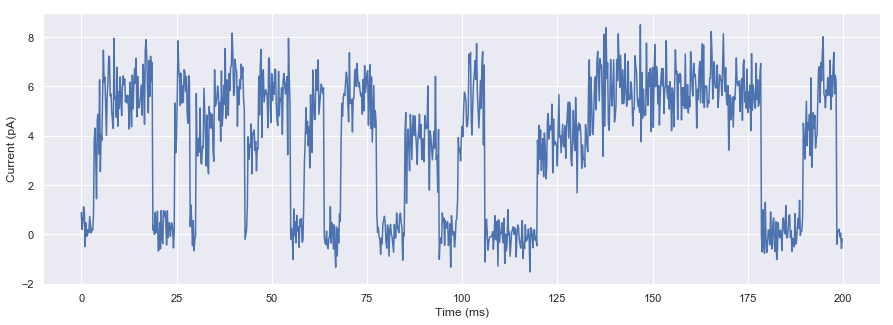

In [77]:
n = 1000

plt.figure(figsize=(15, 5))

plt.plot(time_ms[:n], current_pA[:n])
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)');